## Testing the VGG Face2 Algorithm on A2
The following document carries out a leave one out cross validation on Andreas Karges Album 2.

Install VGGFace2 by executing:

- pip install git+https://github.com/JohannesZahn/keras-vggface.git 
- pip install tensorflow==1.14.0
- pip install keras = 2.2.4

In [54]:
import io
import IPython
import PIL
import pandas as pd
import os
import sklearn
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine
from sklearn.metrics import accuracy_score, recall_score
import numpy as np
import Config
import cv2
import tensorflow as tf
from clustering import cluster
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

In [55]:
model = VGGFace(model='senet50', include_top=False, input_shape=(224,224,3))

104947712/104944616 [==============================] - 17s 0us/step


In [56]:
labels_df = pd.read_csv(Config.LABELS_PATH)
imageNames = os.listdir(Config.EXTRACTED_FACES_PATH)
imageCount = len(imageNames)
faces= np.zeros((imageCount, 224,224,3), dtype=np.float32)
for idx, image_name in enumerate(imageNames):
    image= cv2.imread(os.path.join(Config.EXTRACTED_FACES_PATH,image_name))
    resizedImage = cv2.resize(image, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
    faces[idx, :,:,:] = resizedImage

In [57]:
tf.convert_to_tensor(faces,dtype=tf.float32)
embeddings = model.predict(faces)

-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


C:\Users\Johan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


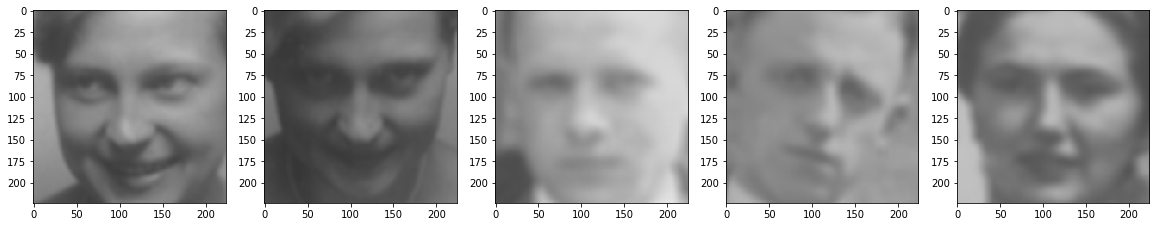

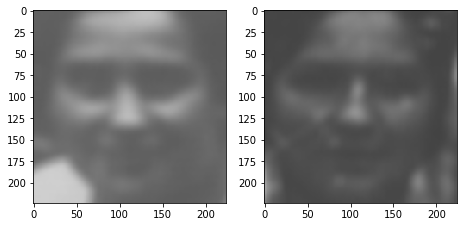

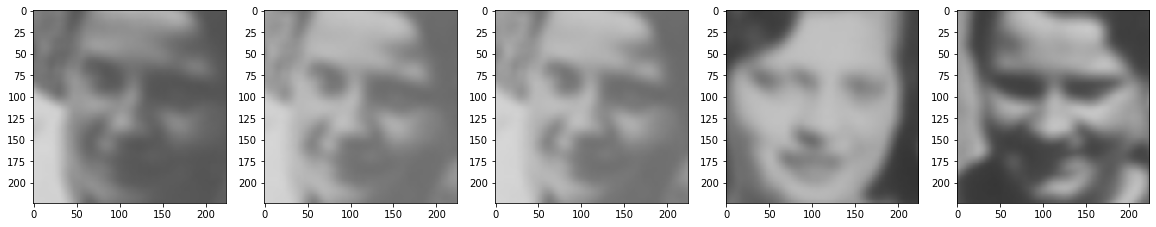

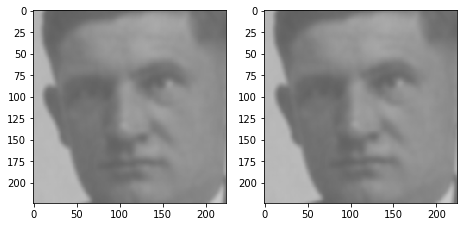

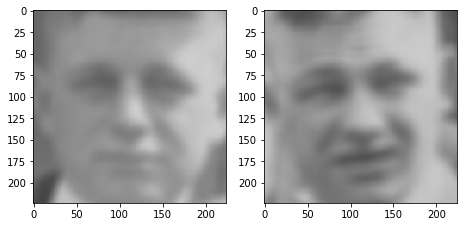

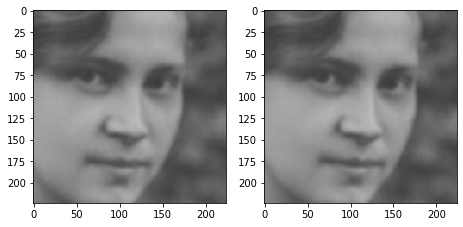

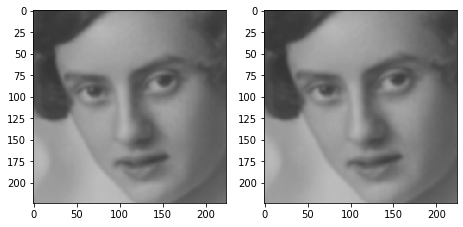

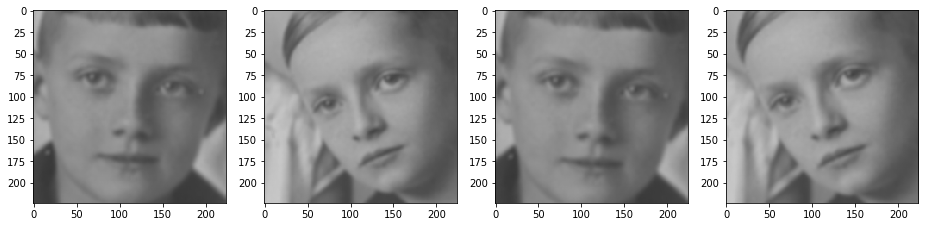

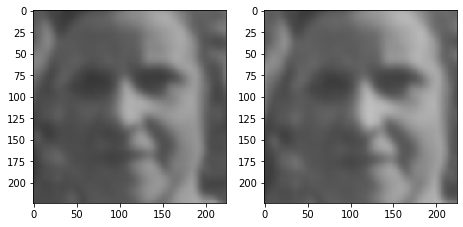

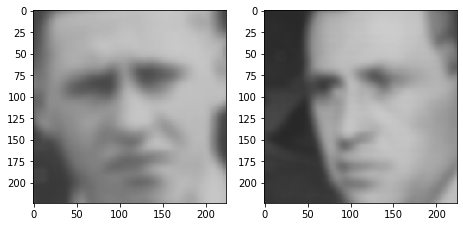

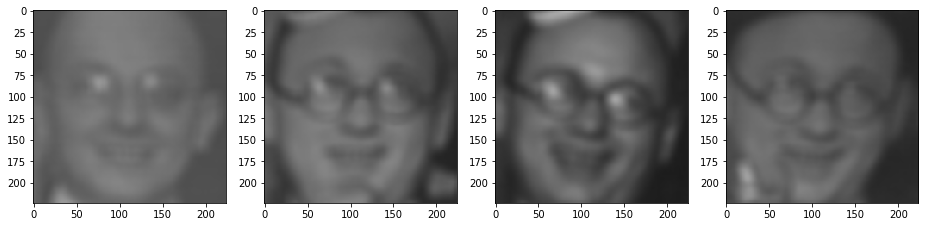

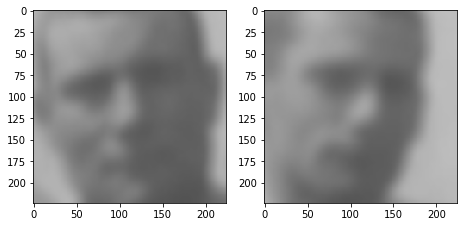

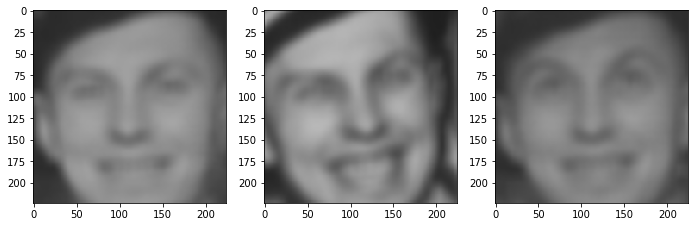

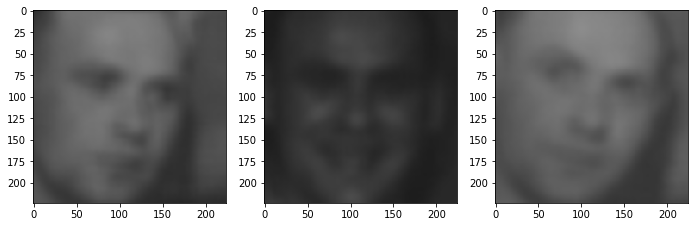

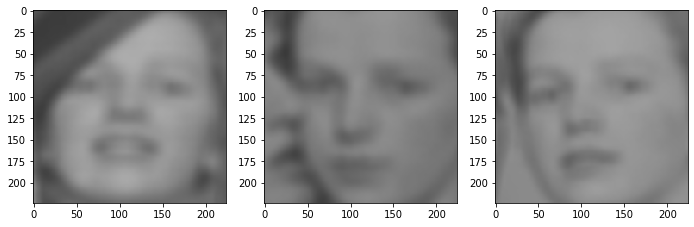

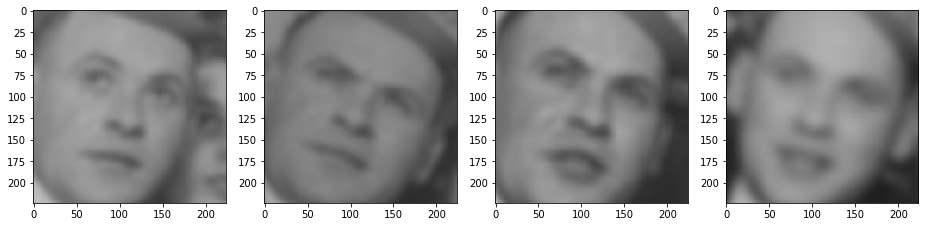

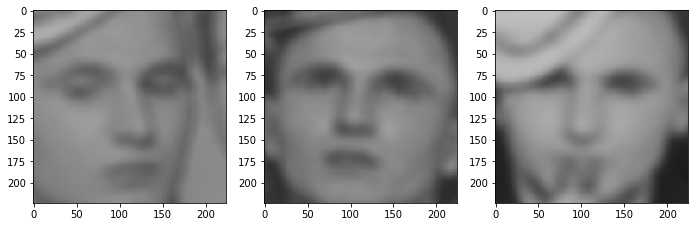

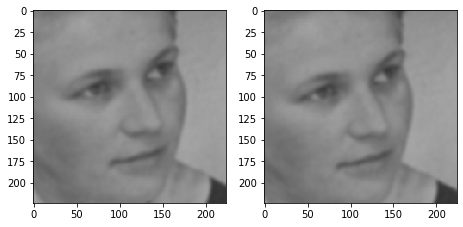

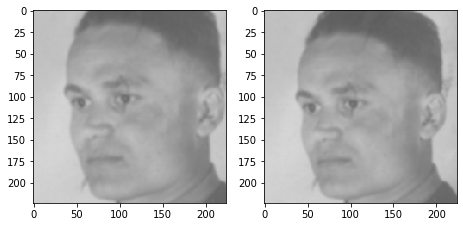

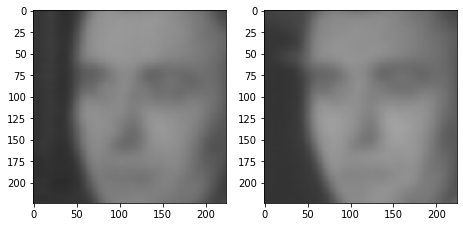

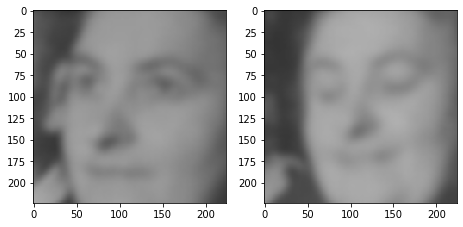

In [65]:
clusters = cluster(embeddings.squeeze(), 0.29, 2, "cosine")
for label in np.unique(clusters.labels_):
    plt.figure(figsize=(20,10))
    columns = 5
    face_indices = np.where(clusters.labels_==label)[0]
    print(str(label))
    for i,face_idx in enumerate(face_indices):
        if i<5:
            plt.subplot(min(5, len(face_indices)) / columns + 1, columns, i + 1)
            plt.imshow(faces[face_idx,:,:,:].squeeze().astype(np.uint8))    
    

In [59]:
np.unique(clusters.labels_)
cv2.imshow('image', faces[1,:,:,:])

In [60]:
threshold = 0.2
accuracies = []
recalls = []
f1s= []
for idx1, embedding1 in enumerate(embeddings):
    label =  labels_df.loc[labels_df['filename'] == imageNames[idx1]].iat[0,1]
    ground_truth = (labels_df['label']== label) & (labels_df['filename'] != imageNames[idx1])
    predictions = []
    for idx2, embedding2 in enumerate(embeddings):
        if idx1!=idx2 and cosine(embedding1,embedding2)<threshold:
            predictions.append(True)    
        else: 
            predictions.append(False)
    acc = accuracy_score(predictions, ground_truth)
    accuracies.append(acc)
    recall = recall_score(predictions, ground_truth)
    recalls.append(recall)
    f1 = sklearn.metrics.f1_score(predictions, ground_truth);
    f1s.append(f1)
    
overall_acc = sum(accuracies)/len(accuracies)
overall_recall = sum(recalls) / len(recalls)
overall_f1 = sum(f1s)/len(f1s)
print('Accuracy: ' + str(overall_acc))
print('Recall: ' + str(overall_recall))

C:\Users\Johan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Johan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Accuracy: 0.9923349809848561
Recall: 0.007314524555903866
